In [251]:
#I sometimes uses these libraries for interactive plots / exploration - they're not necessary for the standard notebook
#import ipywidgets as widgets
#from ipywidgets import interact, interact_manual
#import mplleaflet
#from geopandas import GeoDataFrame
#import multiprocessing

In [252]:
from route_shape_process_scripts import get_most_used_shape_id_per_direction, calc_distance
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
import io
import time
import numpy as np
import math

# point this to your local copy of combined GTFS files --- see notebook `gtfs-realtime/route_shape_process/01_gtfs_transform.ipynb` 

In [253]:
full_routes_gtfs = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_routes_2018-08-15_2018-12-12.csv",low_memory=False)
full_trip_stop_schedule = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_2018-08-15_2018-12-12.csv",low_memory=False)

In [254]:
#create a quick dictionary to convert route short name (easier to remember) with route_id
route_name_to_id_dict = dict(zip(full_routes_gtfs.route_short_name.tolist(),
                                full_routes_gtfs.route_id.tolist()))

# pick a route and direction

In [279]:
route_of_interest = "74"
direction_of_interest = 1
route_id = route_name_to_id_dict[route_of_interest]
shape_id, trip_headsign = get_most_used_shape_id_per_direction(full_trip_stop_schedule, 
                                                               route_id, 
                                                               direction_of_interest)

# generate the file_name and key to pull the transformed data down from AWS S3

In [280]:
base_key = "route_shape_files/"
csv_name = 'transformed/route_{}_{}_shape_{}_node_trips_w_nearest_2018-08-15_2018-12-11.csv'.format(
                                                route_of_interest,
                                                "".join(trip_headsign.replace("/","-").split(" ")) ,
                                                shape_id)

file_key = base_key+csv_name
file_key

'route_shape_files/transformed/route_74_DowntownSeattle_shape_20074007_node_trips_w_nearest_2018-08-15_2018-12-11.csv'

# Import file from S3

In [281]:
s3 = boto3.client("s3")
bucket_name = "malnor.seattle.bustime"
s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
unpacked_positions_full = pd.read_csv(io.BytesIO(s3_object['Body'].read()))

# calculate the distance between the vehicle observations and the `nearest` shape_pt - there are outlier cases where the vehicle locations is very far from the route and should be removed

In [282]:
unpacked_positions_full['distance_btw_veh_and_shape'] = unpacked_positions_full\
                                                                .apply(lambda x: calc_distance(x['vehicle_lat'],
                                                                x['vehicle_long'], 
                                                                x['shape_pt_lat'],
                                                               x['shape_pt_lon']), axis=1)

# plot the distribution of distances

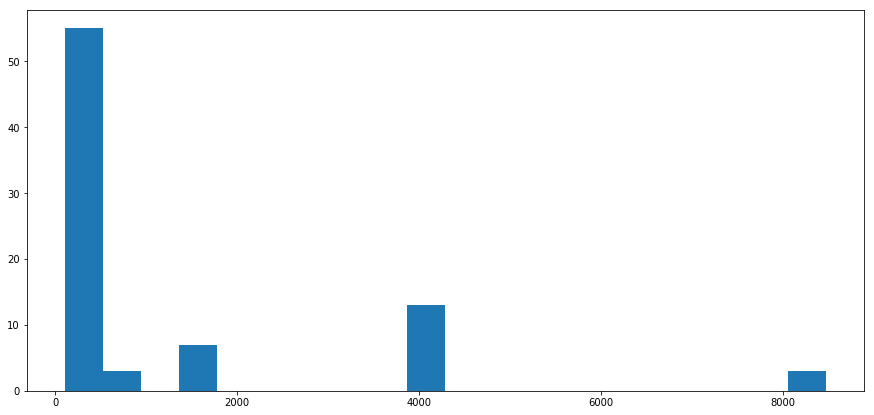

In [283]:
fig, ax = plt.subplots(figsize=(15,7))
_ = ax.hist(unpacked_positions_full\
            [unpacked_positions_full['distance_btw_veh_and_shape']>100]\
            ['distance_btw_veh_and_shape'], bins=20)

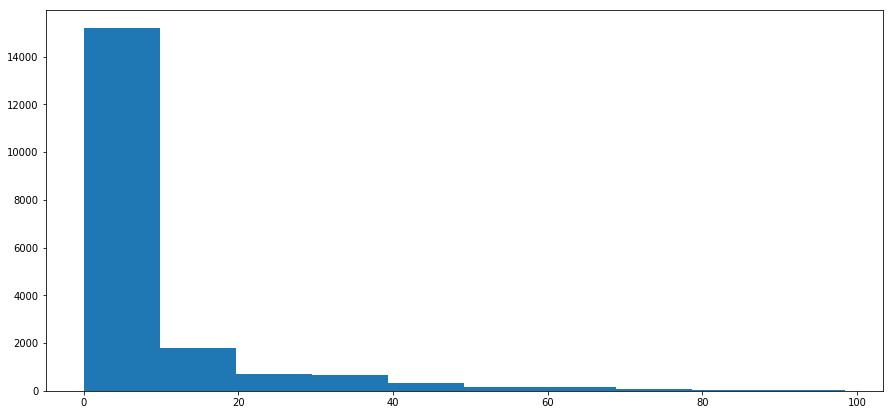

In [284]:
fig, ax = plt.subplots(figsize=(15,7))
_ = ax.hist(unpacked_positions_full\
            [unpacked_positions_full['distance_btw_veh_and_shape']<=100]\
            ['distance_btw_veh_and_shape'])

# remove observations where distance between vehicle and shape pt is >100 meters. remove "backwards" trips and remove outlier speeds

In [285]:
unpacked_positions_clean = unpacked_positions_full\
            [(unpacked_positions_full['distance_btw_veh_and_shape']<=100)&
            (unpacked_positions_full['shape_dist_diff']>=0)&
            (unpacked_positions_full['travel_rate_mph']>=0)&
            (unpacked_positions_full['travel_rate_mph']<80)].copy()

# select peak hours of interest

In [286]:
#Metro “Peak” hours: 6 – 9 a.m. and 3 – 7 p.m
hours_of_interest = [6,7,8,9,15, 16, 17, 18, 19]
unpacked_positions_clean_hours = unpacked_positions_clean\
                                        [unpacked_positions_clean['hour'].isin(hours_of_interest)]

# make a stop_name dictionary - for x_labels on the graph below

In [287]:
stop_name_to_sequence_dict = dict(zip(unpacked_positions_clean_hours.shape_pt_sequence.tolist(),
                        ["" if str(x) == "nan" else x for x in unpacked_positions_clean_hours.stop_name.tolist()]))

# plot average speed across the route

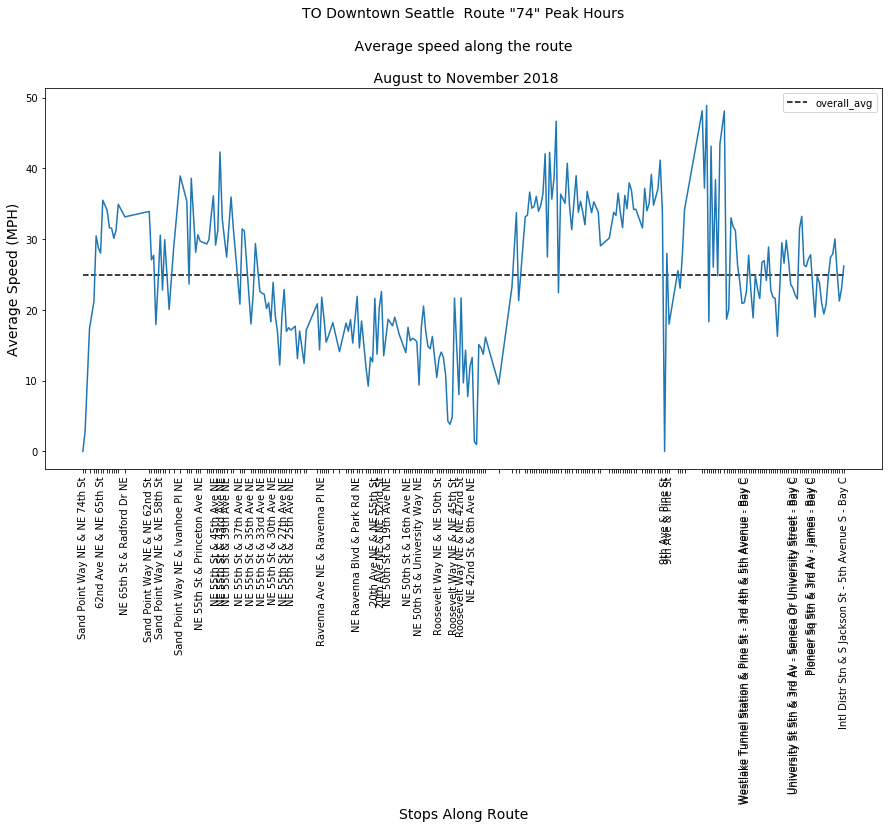

In [294]:
pivot_avg = unpacked_positions_clean_hours.pivot_table(values='travel_rate_mph', 
                                      index='month_day_trip_veh', 
                                      columns='shape_pt_sequence')\
                                        .mean(axis=0)
    
overall_avg = pivot_avg.mean()
x_labels = [stop_name_to_sequence_dict[x_seq] if x_seq in stop_name_to_sequence_dict.keys() else "" for x_seq in x]
fig, ax = plt.subplots(figsize=(15,7))
x = pivot_avg.index
y_avg = pivot_avg.values

#ax.set_xticklabels(x_labels)
plt.xticks(x, x_labels, rotation='vertical')
ax.plot(x, y_avg)
ax.hlines(overall_avg, xmin=min(x), xmax=max(x), label='overall_avg', linestyles='dashed')
ax.set_ylabel("Average Speed (MPH)", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""TO {} Route \"{}\" Peak Hours
                \n Average speed along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
ax.legend()
_ = ax.set_title(title_str, fontsize=14)

# flag all trip segments with travel_rate < threshold 

In [289]:
mph_rate_flag = 10 #can change
unpacked_positions_clean_hours_flag = unpacked_positions_clean_hours.copy()
unpacked_positions_clean_hours_flag['trouble_flag'] = unpacked_positions_clean_hours_flag\
                                                                .apply(lambda x: True if x['travel_rate_mph'] 
                                                                   < mph_rate_flag else False, axis=1)

# plot slowdown areas with only raw observations

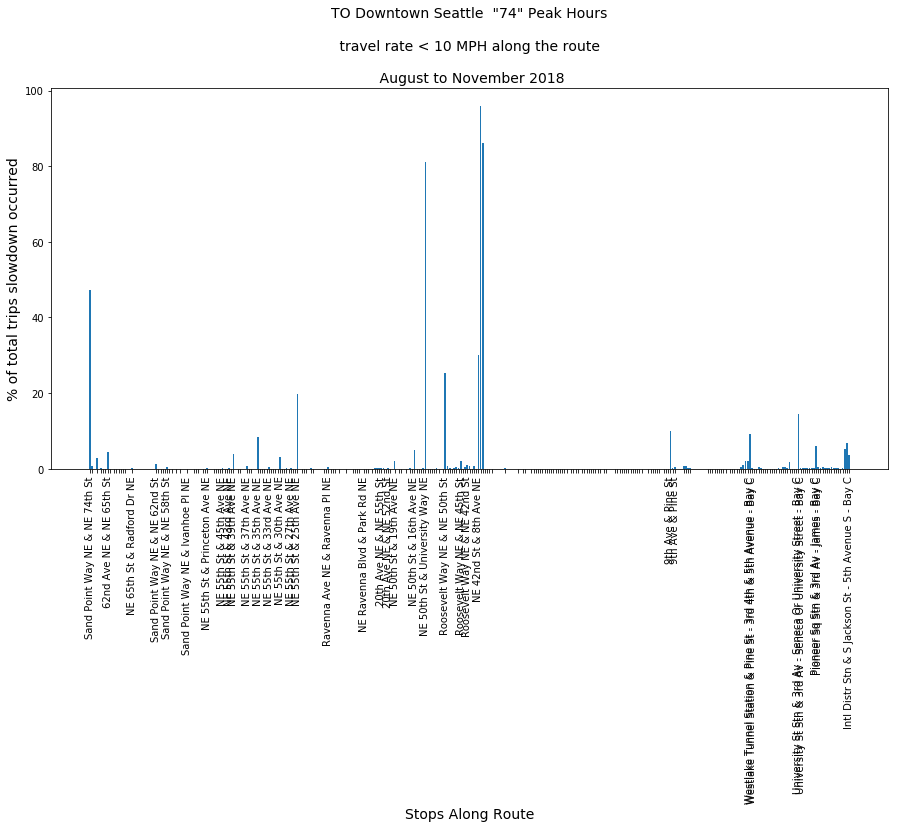

In [298]:
total_trips = len(unpacked_positions_clean_hours_flag.month_day_trip_veh.unique())
pivot_sums = unpacked_positions_clean_hours_flag.pivot_table(values='trouble_flag', 
                                      index='month_day_trip_veh', 
                                      columns='shape_pt_sequence')\
                                        .sum(axis=0)*100/total_trips
x_labels = [stop_name_to_sequence_dict[x] if x in stop_name_to_sequence_dict.keys() else "" for x in x_pos]
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values
#ax.set_xticklabels(x_labels)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.bar(x_pos, bar_h)
ax.set_ylabel("% of total trips slowdown occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""TO {} \"{}\" Peak Hours
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
_ = ax.set_title(title_str, fontsize=14)

# ------------------------------------------------------------------------------------

# the code below can take time to run. only run it if you're curious - I kept it in this notebook in case we ever want to go back to interpolating between observations

# you can compare the raw observations to interpolated observation along segments (below). Note:
1. it's time consuming
2. it produces a similar graph

In [16]:
def get_all_segments_parallel(row):
    '''
    '''
    col_list = ['month_day_trip_veh',
                'trip_hour',
               'time_pct',
               'trip_dow',
               'travel_rate_mph',
                'pt_seq',
               'real_obv',
               'trouble_spot_flag']
    
    month_day_trip_veh = row['month_day_trip_veh']
    trip_hour = row['hour']
    time_pct = row['time_pct']
    trip_dow = row['dow']
    trouble_spot = row['trouble_flag']
    travel_rate_mph = row['travel_rate_mph']
    
    shape_pt_seq_tuple = row['shape_pt_seq_tuple']\
                        .replace("(","")\
                        .replace(")","")\
                        .strip()\
                        .split(",")
    
    pt_seq_start = int(shape_pt_seq_tuple[0])
    pt_seq_end = int(shape_pt_seq_tuple[1])
    #print(pt_seq_start, pt_seq_end)
    full_edge_df = pd.DataFrame()
    for idx, pt_seq in enumerate(range(pt_seq_start,pt_seq_end)):
        edge_for_upload = []
        if idx == 0:
            real_obv = True
        else:
            real_obv = False
        #print(pt_seq)
        info_tuple = (month_day_trip_veh,
                     trip_hour,
                     time_pct,
                     trip_dow,
                     travel_rate_mph,
                      pt_seq,
                     real_obv,
                     trouble_spot)
        edge_for_upload.append(info_tuple)
        edge_df = pd.DataFrame(edge_for_upload, columns=col_list)
        #print("len edge_df = {}".format(len(edge_df)))

        
        if full_edge_df.empty:
            full_edge_df = edge_df.copy()
        else:
            full_edge_df = full_edge_df.append(edge_df)
        #print("len full_edge_df = {}".format(len(full_edge_df)))
    return full_edge_df

In [17]:
def get_segments(df):
    n_pools = multiprocessing.cpu_count() - 1
    pool = multiprocessing.Pool(n_pools)
    row_list = []
    for index, row in df.iterrows():
        row_list.append(row)
    full_edge_df = pd.concat(pool.map(get_all_segments_parallel, row_list))
    return full_edge_df

# !WARNING! This can take a long time if you pick a lot of hours to analyze. 

In [23]:
if __name__ == "__main__":
    start = time.time()
    full_edge_df = get_segments(unpacked_positions_flag_hour)
    end = time.time()
    print(end - start)

511.76262497901917


In [24]:
full_edge_df.head()

,month_day_trip_veh,trip_hour,time_pct,trip_dow,travel_rate_mph,pt_seq,real_obv,trouble_spot_flag
0,2018_10_10_40572126_8063,15,2018-10-10 15:32:13-07:00,2,22.046095,2,True,False
0,2018_10_10_40572126_8063,15,2018-10-10 15:32:13-07:00,2,22.046095,3,False,False
0,2018_10_10_40572126_8063,15,2018-10-10 15:35:38-07:00,2,7.986103,7,True,True
0,2018_10_10_40572126_8063,15,2018-10-10 15:35:38-07:00,2,7.986103,8,False,True
0,2018_10_10_40572126_8063,15,2018-10-10 15:36:08-07:00,2,8.902667,9,True,True


# plot slowdown areas with interpolated segements

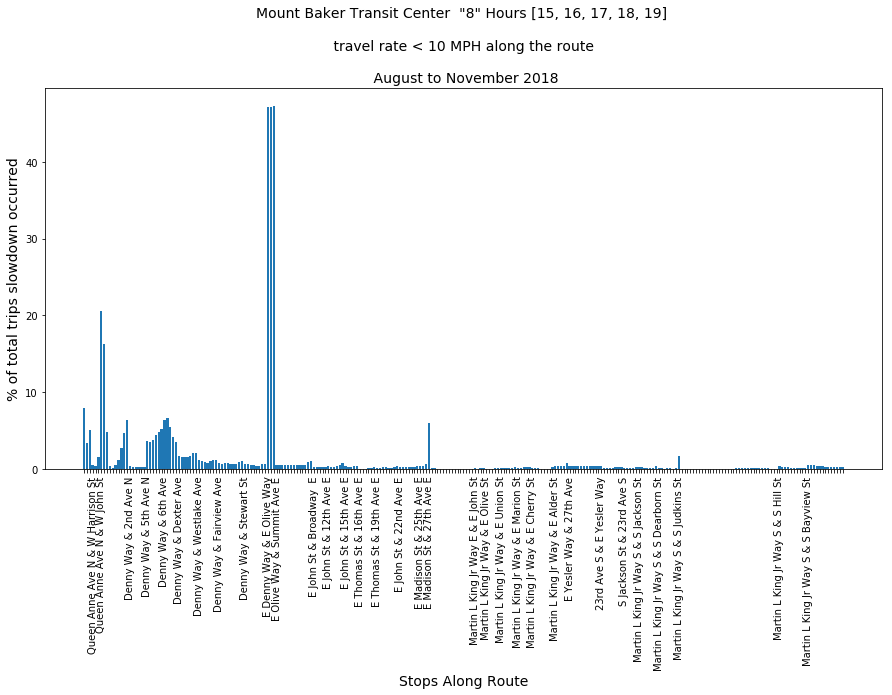

In [59]:
total_trips = len(full_edge_df.month_day_trip_veh.unique())
pivot_sums = full_edge_df.pivot_table(values='trouble_spot_flag', 
                                      index='month_day_trip_veh', 
                                      columns='pt_seq')\
                                        .sum(axis=0)*100/total_trips
x_labels = [stop_name_to_sequence_dict[x] if x in stop_name_to_sequence_dict.keys() else "" for x in x_pos]
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values
#ax.set_xticklabels(x_labels)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.bar(x_pos, bar_h)
ax.set_ylabel("% of total trips slowdown occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""{} \"{}\" Hours {} 
                \n travel rate < 10 MPH along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
_ = ax.set_title(title_str, fontsize=14)